# [2.X코드반영] Lab 12-1: many to one (word sentiment classification)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

print(tf.__version__)

2.4.1


## 데이터셋 준비

In [ ]:
# 예제
words = ['good', 'bad', 'worse', 'so good']
# 긍정 : 1 , 부정 : 0
y_data = [1,0,0,1]

# 토큰 사전 생성
# <pad> 사용 이유 : word를 캐릭터의 시퀀스로 간주했을 때 각각의 시퀀스 길이가 다르기 때문이다.
# RNN을 구현할 때 데이터가 서로 다른 시퀀스의 length를 가진 경우 길이를 맞추기 위해서 pad와 같은 특별한 토큰 사용
char_set = ['<pad>']+sorted(list(set(''.join(words))))
idx2char = {idx: char for idx, char in enumerate(char_set)}
char2idx = {char: idx for idx, char in enumerate(char_set)}

print(char_set)
# 각각의 토큰이 정수 인덱스에 매핑되어있다.
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [ ]:
# 토큰의 시퀀스를 인덱스들의 시퀀스로 변환
x_data = list(map(lambda word: [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word: len(word), x_data))

# 각각의 word가 정수 인덱스의 시퀀스로 변환되어 있다.
print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [ ]:
# 인덱스들의 시퀀스에 패딩
max_sequence = 10

# 변환한 데이터를 pad_sequences로 max_sequence 값만큼 길이로 변환한 데이터를 padding(기본 패딩값 : 0) 한다.
x_data = pad_sequences(sequences=x_data, maxlen=max_sequence, padding='post', truncating='post')

# 데이터 확인
print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


## 모델 생성

In [ ]:
# many to one RNN

input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))
hidden_size = 10
num_classes = 2

model = Sequential()

# Embedding layer는 토큰을 one-hot vector로 표현한다.
# mask_zero=True : 전처리 단계에서 0 값으로 패딩된 부분을 연산에서 제외가능하다.
# trainable=False : one-hot vector를 학습하지 않는다.
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))

# SimpleRNN은 기본적으로 시퀀스의 마지막 토큰을 입력으로 받아 처리한 결과를 반환한다.
model.add(layers.SimpleRNN(units=hidden_size))

# many to one
model.add(layers.Dense(units=num_classes))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 11)            121       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                220       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


embedding (Embedding), (None, 10, 11) : (data dimension, max sequence, input dimension)

simple_rnn (SimpleRNN), (None, 10) : (data dimension, hidden size)

dense (Dense), (None, 2) : (data dimesion, num of class)


## 모델 학습

In [ ]:
# 손실함수
def loss_fn(model, x, y):
  # 모델 출력 : y_pred=model(x)
  # 정답 : y_true=y, 
  # tf.keras.losses.sparse_categorical_crossentropy : y 정수값으로 입력되기 때문
  return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
      y_true=y, y_pred=model(x), from_logits=True))

# 옵티마이저
lr = 0.01
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
# 데이터 파이프라인 생성
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)

print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.int32, tf.int32)>


In [ ]:
# 학습
tr_loss_hist = []

for epoch in range(epochs):
  avg_tr_loss = 0
  tr_step = 0

  for x_mb, y_mb in tr_dataset:
    with tf.GradientTape() as tape: # 미니 배치마다 cross_entropy loss 계산
      tr_loss = loss_fn(model, x=x_mb, y=y_mb)

    # gradient 계산
    grads = tape.gradient(target=tr_loss, sources=model.variables)
    
    # gradien descent 실행
    opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
    avg_tr_loss += tr_loss
    tr_step += 1
  else:
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)

  if (epoch+1) % 5 == 0:
    print('epoch: {:3}, tr_loss: {:.3f}'.format(epoch+1, avg_tr_loss.numpy()))

epoch:   5, tr_loss: 0.008
epoch:  10, tr_loss: 0.003
epoch:  15, tr_loss: 0.002
epoch:  20, tr_loss: 0.001
epoch:  25, tr_loss: 0.001
epoch:  30, tr_loss: 0.001


## 성능 확인

In [ ]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('acc: {:.2%}'.format(np.mean(yhat==y_data)))

acc: 100.00%


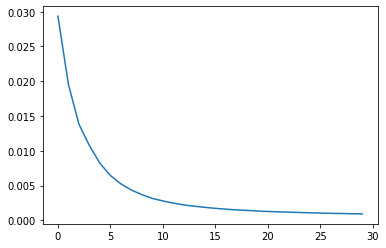

In [ ]:
plt.plot(tr_loss_hist)